# Model to predict the similarity of reported bugs

## Setting up the environment

The expected necessary libraries are imported up front

In [ ]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import metrics

import string
import spacy

### Word embedding using genism

Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community.

Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space.

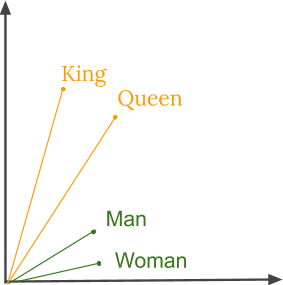

Genism is installed as an API to be used.

In [ ]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))
wv = api.load('glove-twitter-50')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Reading the excel file to variable *dataset*. Key is reduced o integers only by truncating the alphabetical part.

***Key*** is the dependent variable here, while ***Summary*** of the bugs is the indepenedent variable.

In [ ]:
dataset = pd.read_excel('/content/even_better_data_keywords.xlsx')

dataset.head()

,Key,Key_Num,Summary,Summary_Keywords,T
0,791,1,Records sent to validation table due to duplic...,mismatch,bug
1,746,2,- UAT: No result shown in Security Reports fo...,security,improvement
2,873,36,- : How can users see the details of classifi...,classification,bug
3,790,3,Records sent to validation table due to duplicate,duplicate,bug
4,937,43,- UAT: How can users see the details of class...,classification,improvement


## Vectorization and tokenizing
This section is focused on defining some functions to manipulate the summaries of the reported bugs.


spacy_tokenizer: Function to tokenize the string input given to sentence. Each *Summary* is taken as input and broken down into individual words called tokens. Tokens include only meaningful words i.e., punctuations and words which lack impact are stripped while tokenizing.

sent_vec: Function to vectorize the given input to *sent*. The tokens are taken as input and allotted a vector in the vector space to implement word embedding.

In [ ]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):

    doc = nlp(sentence)

    # print(doc)
    # print(type(doc))

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # print(mytokens)

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]


    return mytokens

In [ ]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    # print(wv_res)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

### Stop words and punctuation

Stop words are the words in a stop list (or stoplist or negative dictionary) which are filtered out (i.e. stopped) before or after processing of natural language data (text) because they are insignificant.

A similar approach is taken for handling punctuations.

In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
print(stop_words)

punctuations = string.punctuation
print(punctuations)

{'’re', 'anyone', 'did', 'than', 'yourself', 'top', 'show', 'hereupon', 'me', 'while', 'latter', 'every', 'already', 'for', 'each', 'so', 'may', 're', 'least', 'whereupon', 'what', 'more', 'become', 'except', 'its', 'this', 'to', 'take', 'nobody', 'do', 'neither', 'does', 'further', 'much', 'otherwise', 'put', 'no', 'how', 'whose', 'must', 'own', 'various', 'hence', 'nowhere', 'up', 'ca', 'i', 'under', 'less', 'his', 'whither', 'indeed', '‘re', '’ve', 'my', 'within', '‘m', 'herein', 'former', 'ourselves', 'namely', 'as', 'perhaps', 'her', 'whence', 'without', 'elsewhere', 'everywhere', 'first', 'that', 'sixty', 'ours', 'therein', 'either', 'themselves', 'together', 'mostly', 'he', 'because', 'on', 'through', 'during', 'mine', 'beyond', 'fifty', 'eight', 'whole', 'someone', 'been', 'can', 'both', 'was', 'thereby', 'wherever', 'besides', 'rather', 'whenever', 'were', 'itself', 'whatever', 'call', 'anywhere', 'whom', 'a', 'eleven', 'somewhere', 'these', 'anyway', "'m", 'at', 'seems', '’d'

Summary of the bugs are tokenized and stored in ***tokens_sum***

In [ ]:
dataset['tokens_sum'] = dataset['Summary'].apply(spacy_tokenizer)

Tokenized summaries are vectorized and stored in ***vectors_sum***

In [ ]:
dataset['vectors_sum'] = dataset['tokens_sum'].apply(sent_vec)

The keys of the bugs are used for identification and stored in variable ***y***

In [ ]:
y = dataset.iloc[:, 0].values

The vectors of the summaries are stored in variable ***X***

In [ ]:
X = dataset['vectors_sum'].tolist()

## Training and testing datasets

The pairs of keys and summaries are split into training and testing datasets and stored.
The dataset is split into two parts. 80% of the data is used for training the model and 20% of the data is used for testing the model's accuracy.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Logistic regression

Logistic regression classifies the bug into discrete outputs and represents the probability of classifying one bug as a certain type. The model is trained using maximum likelihood estimation, and the decision boundary is a linear analysis of summary, making it a simple yet effective algorithm for classifying data into distinct classes.

In this section, the model is trained by calling the Logistic Regression classifier and taking the X and y training sets as input.

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

## Accuracy of model

In this section, the trained model is used to predict the output of the testing set by taking ***X_test*** as input and storing the predicted output in the variable ***predicted***

Mean Absolute Error(MAE) and Mean Absolute Percentage Error(MAPE) are used as metrics based on the nature of the classification task and the performance of logistic regression model is determined by comparing predicted values of X_test**(predicted)** against true values of X_test**(y_test)**.


*   MAE : It measures the average absolute difference between predicted and actual values.
*   MAPE : It calculates the average percentage difference between predicted and actual values.



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
predicted = classifier.predict(X_test)

print("Logistic Regression Mean Absolute Error:",mean_absolute_error(y_test, predicted))
print("Logistic Regression Mean Absolute Percentage Error:",mean_absolute_percentage_error(y_test, predicted))

Logistic Regression Mean Absolute Error: 132.0
Logistic Regression Mean Absolute Percentage Error: 0.16649336283185842


In [ ]:
print('Input Summary: "', X_test[1], '" corresponds to the key', predicted[1])

Input Summary: "FRW file layout doesn't match data mapping specs provided in the shared point" corresponds to the key 535